In [1]:
import cv2
import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Configuration
RESULTS_DIR = "ML_Results"
MODELS_DIR = os.path.join(RESULTS_DIR, "Trained_Models")
EXP_DIR = os.path.join(RESULTS_DIR, "Experiments")
SUMMARY_DIR = os.path.join(RESULTS_DIR, "Summary")

for d in [MODELS_DIR, EXP_DIR, SUMMARY_DIR]:
    os.makedirs(d, exist_ok=True)

BASE_DIR = os.getcwd()
DATA_ROOT = os.path.join(BASE_DIR, "SegmentedData")

# Feature Extraction

In [2]:
def extract_features_robust(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    img = cv2.resize(img, (64, 64))
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    mask = img_gray > 5
    mask_uint8 = mask.astype(np.uint8) * 255
    
    if np.sum(mask) == 0:
        return np.zeros(88) 

    features = []
    
    # 1. Smart Stats (Mean and Std on non-black pixels)
    # RGB Channels
    for i in range(3):
        channel_pixels = img_rgb[:, :, i][mask]
        features.append(np.mean(channel_pixels))
        features.append(np.std(channel_pixels))
        
    # HSV Channels
    for i in range(3):
        channel_pixels = img_hsv[:, :, i][mask]
        features.append(np.mean(channel_pixels))
        features.append(np.std(channel_pixels))
        
    # 2. Top Percentiles (90, 95, 99) for Saturation and Value
    # This helps detect small, highly saturated parasite points
    s_pixels = img_hsv[:, :, 1][mask]
    v_pixels = img_hsv[:, :, 2][mask]
    
    for p in [90, 95, 99]:
        features.append(np.percentile(s_pixels, p))
        features.append(np.percentile(v_pixels, p))
        
    # 3. Normalized Color Histograms (32 bins)
    # H Channel (Hue)
    hist_h = cv2.calcHist([img_hsv], [0], mask_uint8, [32], [0, 180])
    cv2.normalize(hist_h, hist_h, alpha=1, norm_type=cv2.NORM_L1)
    features.extend(hist_h.flatten())
    
    # S Channel (Saturation)
    hist_s = cv2.calcHist([img_hsv], [1], mask_uint8, [32], [0, 256])
    cv2.normalize(hist_s, hist_s, alpha=1, norm_type=cv2.NORM_L1)
    features.extend(hist_s.flatten())
    
    return np.array(features)

# Data Loader

In [ ]:
def load_image_data(root_path):
    X, y = [], []
    metadata = []
    
    label_map = {'Parasitized': 1, 'Uninfected': 0, 'WBC': 0}
    
    print(f"Loading data from: {root_path[-60:]}")
    start_t = time.time()
    
    for root, _, files in os.walk(root_path):
        folder_name = os.path.basename(root)
        
        current_label = None
        for key, val in label_map.items():
            if key.lower() in folder_name.lower():
                current_label = val
                break
        
        if current_label is None: continue

        path_parts = root.split(os.sep)
        image_id = path_parts[-2]
        patient_id = path_parts[-3]

        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(root, file)
                features = extract_features_robust(img_path)
                
                if features is not None:
                    X.append(features)
                    y.append(current_label)
                    metadata.append({'Patient': patient_id, 'Image': image_id})

    print(f"Loaded {len(X)} cells in {time.time() - start_t:.1f}s")
    return np.array(X), np.array(y), pd.DataFrame(metadata)

# Training/Evaluation Functions

In [4]:
def train_and_save(model, X_train, y_train, save_name):
    print(f"Training model for: {save_name}")
    start_time = time.time()
    
    model.fit(X_train, y_train)
    
    duration = time.time() - start_time
    print(f"Training completed in {duration:.2f}s")
    
    save_path = os.path.join(MODELS_DIR, f"{save_name}.pkl")
    with open(save_path, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model saved to {save_path}")
    return model

In [5]:
def evaluate_model(model, X_test, y_test, meta_test, experiment_name):
    print(f"Evaluating: {experiment_name}")
    
    t0 = time.time()
    y_pred = model.predict(X_test)
    total_inference_time = (time.time() - t0) * 1000 
    
    avg_pred_time_per_cell = total_inference_time / len(y_test)
    est_feature_time_per_cell = 10 
    
    metrics = {
        'Experiment': experiment_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1_Score': f1_score(y_test, y_pred, zero_division=0)
    }
    
    df_res = meta_test.copy()
    df_res['True_Label'] = y_test
    df_res['Pred_Label'] = y_pred
    
    img_stats = []
    
    for (pid, img_id), group in df_res.groupby(['Patient', 'Image']):
        n_cells = len(group)
        n_true = group['True_Label'].sum()
        n_pred = group['Pred_Label'].sum()
        
        true_rate = n_true / n_cells
        pred_rate = n_pred / n_cells
        error = abs(true_rate - pred_rate)
        
        img_time = n_cells * (est_feature_time_per_cell + avg_pred_time_per_cell)
        
        img_stats.append({
            'Patient_ID': pid,
            'Image_ID': img_id,
            'N_Cells': n_cells,
            'True_Parasitemia': true_rate,
            'Pred_Parasitemia': pred_rate,
            'Error_MAE': error,
            'Inference_Time_ms': img_time
        })
        
    df_img_stats = pd.DataFrame(img_stats)
    
    log_path = os.path.join(EXP_DIR, f"{experiment_name}_per_frame.csv")
    df_img_stats.to_csv(log_path, index=False)
    
    metrics['Mean_Parasitemia_Error'] = df_img_stats['Error_MAE'].mean()
    metrics['Avg_Time_Per_Image_ms'] = df_img_stats['Inference_Time_ms'].mean()
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"CM: {experiment_name}")
    plt.savefig(os.path.join(EXP_DIR, f"{experiment_name}_cm.png"))
    plt.close()
    
    return metrics

# Training Models

In [6]:
POLYGON_DATA_DIR = os.path.join(BASE_DIR, DATA_ROOT, "Polygon_Data")

train_sources = {
    'GT_Black':      os.path.join(POLYGON_DATA_DIR, 'Train', 'GT', 'black_background'),
    'GT_Original':   os.path.join(POLYGON_DATA_DIR, 'Train', 'GT', 'original_background'),
    'Seg_Watershed': os.path.join(POLYGON_DATA_DIR, 'Train', 'Seg', 'Watershed'),
    'Seg_Hough':     os.path.join(POLYGON_DATA_DIR, 'Train', 'Seg', 'Hough')
}

test_sources = {
    'GT_Black':      os.path.join(POLYGON_DATA_DIR, 'Test', 'GT', 'black_background'),
    'GT_Original':   os.path.join(POLYGON_DATA_DIR, 'Test', 'GT', 'original_background'),
    'Seg_Watershed': os.path.join(POLYGON_DATA_DIR, 'Test', 'Seg', 'Watershed'),
    'Seg_Hough':     os.path.join(POLYGON_DATA_DIR, 'Test', 'Seg', 'Hough')
}

In [7]:
print(f"Checking paths in {DATA_ROOT}")
for name, path in train_sources.items():
    print(f"{name}: {'Found' if os.path.exists(path) else 'Not Found'}")

Checking paths in c:\Users\Polina\Documents\Python_files\AI\Computer_Vision\Malaria_Screening\SegmentedData
GT_Black: Found
GT_Original: Found
Seg_Watershed: Found
Seg_Hough: Found


In [9]:
models_config = {
    'LogisticRegression': make_pipeline(
        StandardScaler(), 
        LogisticRegression(
            C=100, 
            max_iter=500, 
            penalty='l2', 
            solver='lbfgs', 
            random_state=42
        )
    ),
    
    'RandomForest': RandomForestClassifier(
        n_estimators=300, 
        max_depth=20, 
        max_features='sqrt', 
        min_samples_leaf=2, 
        min_samples_split=5, 
        bootstrap=False, 
        random_state=42, 
        n_jobs=-1
    ),
    
    'SVM': make_pipeline(
        StandardScaler(), 
        SVC(kernel='rbf', probability=True, random_state=42)
    )
}

In [10]:
trained_models_db = {}

for source_name, source_path in train_sources.items():
    if not os.path.exists(source_path):
        print(f"Skipping training source {source_name}: Path not found")
        continue

    print(f"\nLoading Training Data: {source_name}")
    X_train, y_train, _ = load_image_data(source_path)
    
    if len(X_train) == 0:
        print(f"No data found in {source_name}")
        continue

    trained_models_db[source_name] = {}

    for model_name, model_instance in models_config.items():
        unique_id = f"{model_name}_trained_on_{source_name}"
        
        # Clone model to avoid overwriting
        from sklearn.base import clone
        model_to_train = clone(model_instance)
        
        trained = train_and_save(model_to_train, X_train, y_train, unique_id)
        trained_models_db[source_name][model_name] = trained


Loading Training Data: GT_Black
Loading data from: reening\SegmentedData\Polygon_Data\Train\GT\black_background
Loaded 20385 cells in 35.6s
Training model for: LogisticRegression_trained_on_GT_Black
Training completed in 0.82s
Model saved to ML_Results\Trained_Models\LogisticRegression_trained_on_GT_Black.pkl
Training model for: RandomForest_trained_on_GT_Black
Training completed in 12.30s
Model saved to ML_Results\Trained_Models\RandomForest_trained_on_GT_Black.pkl
Training model for: SVM_trained_on_GT_Black
Training completed in 22.71s
Model saved to ML_Results\Trained_Models\SVM_trained_on_GT_Black.pkl

Loading Training Data: GT_Original
Loading data from: ning\SegmentedData\Polygon_Data\Train\GT\original_background
Loaded 20385 cells in 355.9s
Training model for: LogisticRegression_trained_on_GT_Original
Training completed in 0.70s
Model saved to ML_Results\Trained_Models\LogisticRegression_trained_on_GT_Original.pkl
Training model for: RandomForest_trained_on_GT_Original
Training

In [11]:
master_results = []

# Define testing rules based on training source
testing_rules = {
    'GT_Black':      ['GT_Black', 'Seg_Watershed'],
    'GT_Original':   ['GT_Original', 'Seg_Hough'],
    'Seg_Watershed': ['Seg_Watershed'],
    'Seg_Hough':     ['Seg_Hough']
}

for train_source, models_dict in trained_models_db.items():
    if train_source not in testing_rules: continue
    
    target_test_sets = testing_rules[train_source]
    
    for test_name in target_test_sets:
        test_path = test_sources.get(test_name)
        if not test_path or not os.path.exists(test_path):
            print(f"Test path not found: {test_name}")
            continue
            
        print(f"\nTesting models trained on {train_source} against {test_name}")
        X_test, y_test, meta_test = load_image_data(test_path)
        
        if len(X_test) == 0: continue
        
        for model_name, model in models_dict.items():
            exp_id = f"{model_name}_Train_{train_source}_Test_{test_name}"
            
            metrics = evaluate_model(model, X_test, y_test, meta_test, exp_id)
            
            metrics['Model'] = model_name
            metrics['Train_Source'] = train_source
            metrics['Test_Target'] = test_name
            master_results.append(metrics)

df_master = pd.DataFrame(master_results)
cols = ['Model', 'Train_Source', 'Test_Target', 'F1_Score', 'Recall', 'Precision', 'Mean_Parasitemia_Error', 'Avg_Time_Per_Image_ms', 'Experiment']
df_master = df_master[cols]

df_master.to_csv(os.path.join(SUMMARY_DIR, "Master_Results_Matrix.csv"), index=False)


Testing models trained on GT_Black against GT_Black
Loading data from: creening\SegmentedData\Polygon_Data\Test\GT\black_background
Loaded 8891 cells in 146.3s
Evaluating: LogisticRegression_Train_GT_Black_Test_GT_Black
Evaluating: RandomForest_Train_GT_Black_Test_GT_Black
Evaluating: SVM_Train_GT_Black_Test_GT_Black

Testing models trained on GT_Black against Seg_Watershed
Loading data from: aria_Screening\SegmentedData\Polygon_Data\Test\Seg\Watershed
Loaded 7668 cells in 102.1s
Evaluating: LogisticRegression_Train_GT_Black_Test_Seg_Watershed
Evaluating: RandomForest_Train_GT_Black_Test_Seg_Watershed
Evaluating: SVM_Train_GT_Black_Test_Seg_Watershed

Testing models trained on GT_Original against GT_Original
Loading data from: ening\SegmentedData\Polygon_Data\Test\GT\original_background
Loaded 8891 cells in 142.5s
Evaluating: LogisticRegression_Train_GT_Original_Test_GT_Original
Evaluating: RandomForest_Train_GT_Original_Test_GT_Original
Evaluating: SVM_Train_GT_Original_Test_GT_Origi

In [13]:
df_master['Mean_Parasitemia_Error'] = df_master['Mean_Parasitemia_Error'] * 100
display(df_master)

,Model,Train_Source,Test_Target,F1_Score,Recall,Precision,Mean_Parasitemia_Error,Avg_Time_Per_Image_ms,Experiment
0,LogisticRegression,GT_Black,GT_Black,0.790062,0.764423,0.817481,1.660572,2222.999308,LogisticRegression_Train_GT_Black_Test_GT_Black
1,RandomForest,GT_Black,GT_Black,0.840108,0.745192,0.962733,1.281712,2226.306514,RandomForest_Train_GT_Black_Test_GT_Black
2,SVM,GT_Black,GT_Black,0.868526,0.786058,0.970326,1.035928,2265.248344,SVM_Train_GT_Black_Test_GT_Black
3,LogisticRegression,GT_Black,Seg_Watershed,0.478764,0.433566,0.534483,4.358192,1917.151575,LogisticRegression_Train_GT_Black_Test_Seg_Wat...
4,RandomForest,GT_Black,Seg_Watershed,0.613953,0.461538,0.916667,3.253493,1920.478503,RandomForest_Train_GT_Black_Test_Seg_Watershed
5,SVM,GT_Black,Seg_Watershed,0.592941,0.440559,0.906475,3.421873,1941.058586,SVM_Train_GT_Black_Test_Seg_Watershed
6,LogisticRegression,GT_Original,GT_Original,0.407534,0.286058,0.708333,3.563269,2222.925935,LogisticRegression_Train_GT_Original_Test_GT_O...
7,RandomForest,GT_Original,GT_Original,0.744565,0.658654,0.856250,1.265341,2225.188879,RandomForest_Train_GT_Original_Test_GT_Original
8,SVM,GT_Original,GT_Original,0.688666,0.576923,0.854093,1.851890,2244.199769,SVM_Train_GT_Original_Test_GT_Original
9,LogisticRegression,GT_Original,Seg_Hough,0.327273,0.250000,0.473684,4.049211,2580.923920,LogisticRegression_Train_GT_Original_Test_Seg_...


In [15]:
from IPython.display import display, Markdown

train_sources = df_master['Train_Source'].unique()

for source in train_sources:
    display(Markdown(f"Train_Source: {source}"))
    display(df_master[df_master['Train_Source'] == source].drop(columns=['Experiment']))

Train_Source: GT_Black

,Model,Train_Source,Test_Target,F1_Score,Recall,Precision,Mean_Parasitemia_Error,Avg_Time_Per_Image_ms
0,LogisticRegression,GT_Black,GT_Black,0.790062,0.764423,0.817481,1.660572,2222.999308
1,RandomForest,GT_Black,GT_Black,0.840108,0.745192,0.962733,1.281712,2226.306514
2,SVM,GT_Black,GT_Black,0.868526,0.786058,0.970326,1.035928,2265.248344
3,LogisticRegression,GT_Black,Seg_Watershed,0.478764,0.433566,0.534483,4.358192,1917.151575
4,RandomForest,GT_Black,Seg_Watershed,0.613953,0.461538,0.916667,3.253493,1920.478503
5,SVM,GT_Black,Seg_Watershed,0.592941,0.440559,0.906475,3.421873,1941.058586


Train_Source: GT_Original

,Model,Train_Source,Test_Target,F1_Score,Recall,Precision,Mean_Parasitemia_Error,Avg_Time_Per_Image_ms
6,LogisticRegression,GT_Original,GT_Original,0.407534,0.286058,0.708333,3.563269,2222.925935
7,RandomForest,GT_Original,GT_Original,0.744565,0.658654,0.856250,1.265341,2225.188879
8,SVM,GT_Original,GT_Original,0.688666,0.576923,0.854093,1.851890,2244.199769
9,LogisticRegression,GT_Original,Seg_Hough,0.327273,0.250000,0.473684,4.049211,2580.923920
10,RandomForest,GT_Original,Seg_Hough,0.673036,0.587037,0.788557,1.458133,2583.191299
11,SVM,GT_Original,Seg_Hough,0.613537,0.520370,0.747340,2.092246,2611.434125


Train_Source: Seg_Watershed

,Model,Train_Source,Test_Target,F1_Score,Recall,Precision,Mean_Parasitemia_Error,Avg_Time_Per_Image_ms
12,LogisticRegression,Seg_Watershed,Seg_Watershed,0.556660,0.489510,0.645161,3.575198,1917.158495
13,RandomForest,Seg_Watershed,Seg_Watershed,0.616822,0.461538,0.929577,3.328107,1919.650917
14,SVM,Seg_Watershed,Seg_Watershed,0.640732,0.489510,0.927152,2.984985,1947.867660


Train_Source: Seg_Hough

,Model,Train_Source,Test_Target,F1_Score,Recall,Precision,Mean_Parasitemia_Error,Avg_Time_Per_Image_ms
15,LogisticRegression,Seg_Hough,Seg_Hough,0.143070,0.088889,0.366412,4.572687,2580.924659
16,RandomForest,Seg_Hough,Seg_Hough,0.461738,0.329630,0.770563,2.981122,2583.265966
17,SVM,Seg_Hough,Seg_Hough,0.559719,0.442593,0.761146,2.421471,2628.892684


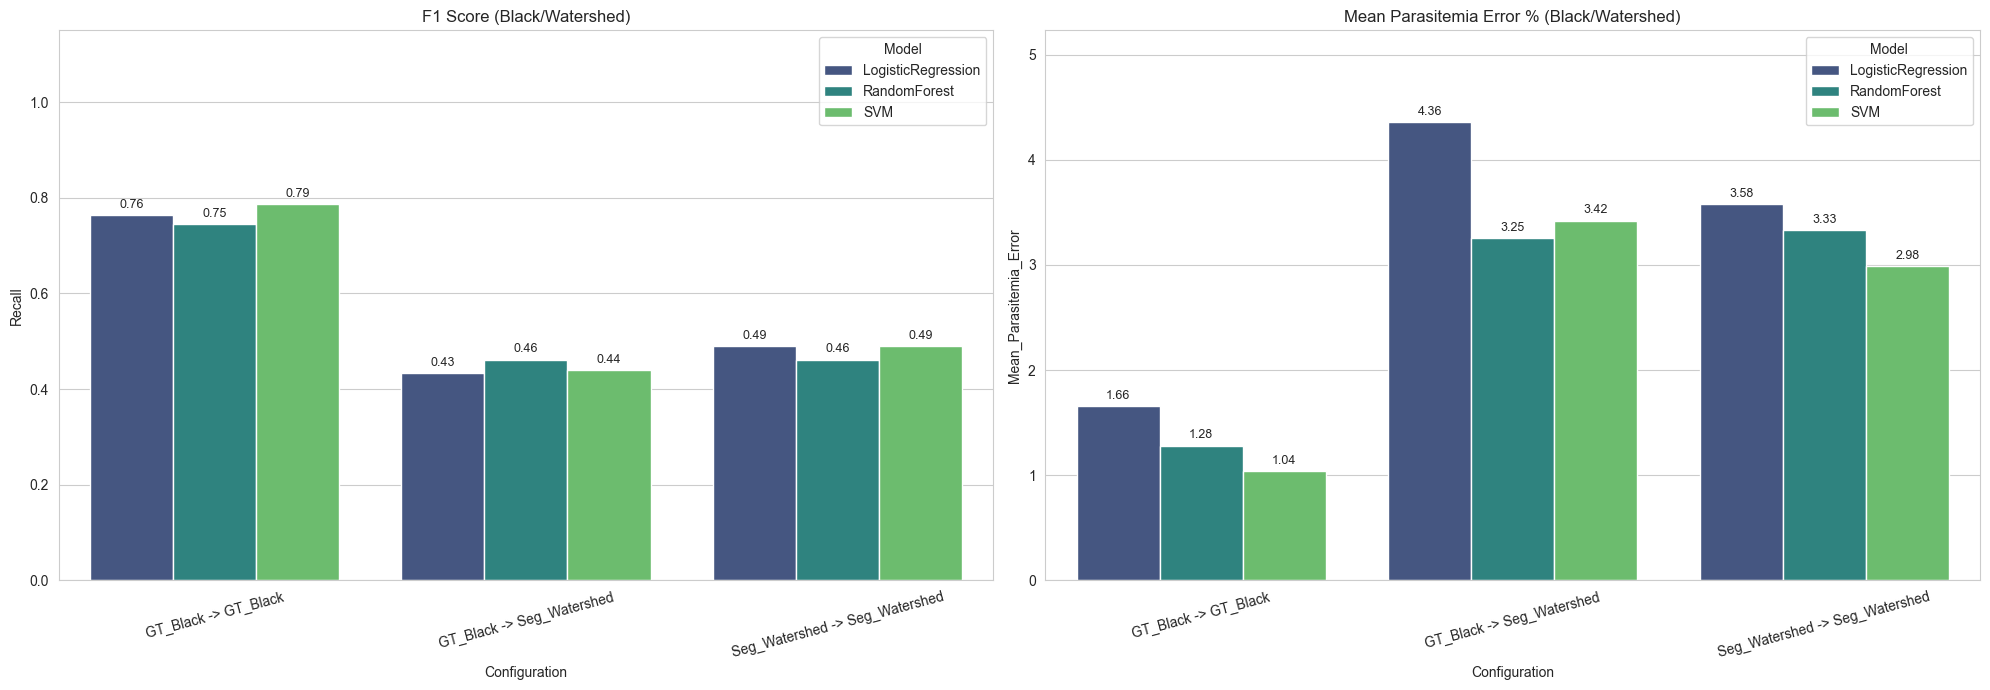

In [19]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})

group1_mask = df_master['Train_Source'].isin(['GT_Black', 'Seg_Watershed'])
df_group1 = df_master[group1_mask].copy()
df_group1['Configuration'] = df_group1.apply(lambda row: f"{row['Train_Source']} -> {row['Test_Target']}", axis=1)

fig1, axes1 = plt.subplots(1, 2, figsize=(20, 7))

sns.barplot(data=df_group1, x='Configuration', y='Recall', hue='Model', ax=axes1[0], palette='viridis')
axes1[0].set_title('F1 Score (Black/Watershed)')
axes1[0].set_ylim(0, 1.15)
axes1[0].tick_params(axis='x', rotation=15)

for container in axes1[0].containers:
    axes1[0].bar_label(container, fmt='%.2f', padding=3, fontsize=9)

sns.barplot(data=df_group1, x='Configuration', y='Mean_Parasitemia_Error', hue='Model', ax=axes1[1], palette='viridis')
axes1[1].set_title('Mean Parasitemia Error % (Black/Watershed)')
axes1[1].set_ylim(0, df_group1['Mean_Parasitemia_Error'].max() * 1.2)
axes1[1].tick_params(axis='x', rotation=15)

for container in axes1[1].containers:
    axes1[1].bar_label(container, fmt='%.2f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

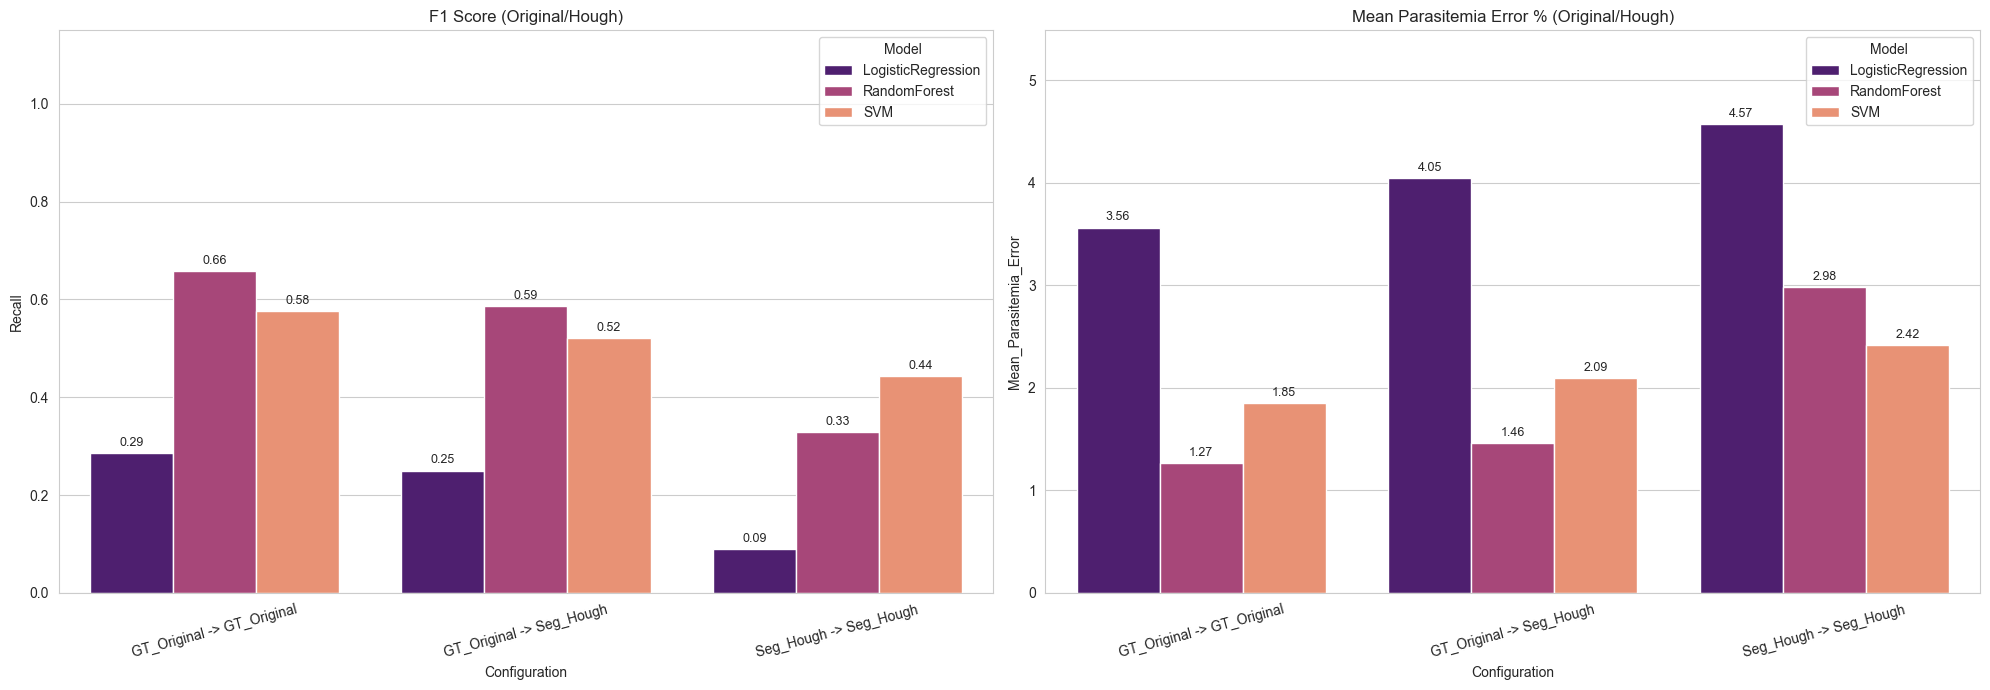

In [20]:
group2_mask = df_master['Train_Source'].isin(['GT_Original', 'Seg_Hough'])
df_group2 = df_master[group2_mask].copy()
df_group2['Configuration'] = df_group2.apply(lambda row: f"{row['Train_Source']} -> {row['Test_Target']}", axis=1)

fig2, axes2 = plt.subplots(1, 2, figsize=(20, 7))

sns.barplot(data=df_group2, x='Configuration', y='Recall', hue='Model', ax=axes2[0], palette='magma')
axes2[0].set_title('F1 Score (Original/Hough)')
axes2[0].set_ylim(0, 1.15)
axes2[0].tick_params(axis='x', rotation=15)

for container in axes2[0].containers:
    axes2[0].bar_label(container, fmt='%.2f', padding=3, fontsize=9)

sns.barplot(data=df_group2, x='Configuration', y='Mean_Parasitemia_Error', hue='Model', ax=axes2[1], palette='magma')
axes2[1].set_title('Mean Parasitemia Error % (Original/Hough)')
axes2[1].set_ylim(0, df_group2['Mean_Parasitemia_Error'].max() * 1.2)
axes2[1].tick_params(axis='x', rotation=15)

for container in axes2[1].containers:
    axes2[1].bar_label(container, fmt='%.2f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()